<a href="https://colab.research.google.com/github/Heba-Atef99/Head_Pose_Estimation/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proplem Definition
Our problem is estimating the head pose using the three angles: (pitch, yaw, roll). As our input is an image of the face and the output is an image with three axes defining its position.

<center>
<img src="https://d226lax1qjow5r.cloudfront.net/blog/blogposts/attention-detection-with-vonage-video-api/46a877a98c1af6eae4a547a5248a315f.png" align="center"/>

<img src="https://miro.medium.com/max/691/1*U4ZQ8UjzouVMRo2Fgsz7UA.png" width='50%' align="center"/>
</center>


# Dataset
We will use AFLW2000 dataset which is a dataset of 2000 images that have been annotated with image-level 68-point 3D facial landmarks.

You can refer to the dataset [here](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/main.htm)

<center>
<img src="https://production-media.paperswithcode.com/datasets/AFLW2000-3D-0000000545-76d6b875_KNCUxRx.jpg" align="center" width='40%'/>
</center>

# 1. Import Libraries

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 26.5 MB/s eta 0:00:00


In [100]:
import pandas as pd
import os
from math import cos, sin
import cv2
import mediapipe as mp
from scipy.io import loadmat
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# 2. Loading & Preparing Images

Mount the cotents of drive into the files of colab to access the AFLW2000 zip file

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy the zip file fo from drive to the content folder on google colab

In [4]:
!cp /content/drive/MyDrive/Head_Pose_Estimation/AFLW2000-3D.zip /content

unzip the file

In [ ]:
dataset_path = '/content/AFLW2000'
if not os.path.exists(dataset_path):
  %cd /content
  !unzip AFLW2000-3D.zip;

collect the images' names and save it into a dataframe

In [6]:
dir_list = os.listdir(dataset_path)

In [7]:
images_list = list(filter(lambda file: file.endswith('.jpg'), dir_list))
images_names = list(map(lambda file: dataset_path + '/' + file.replace('.jpg', '') , images_list))

In [8]:
images_names[:5]

['/content/AFLW2000/image01598',
 '/content/AFLW2000/image01097',
 '/content/AFLW2000/image01506',
 '/content/AFLW2000/image02556',
 '/content/AFLW2000/image00667']

save the images names in a dataframe

In [22]:
df = pd.DataFrame(images_names, columns=['image'])
df.head()

,image
0,/content/AFLW2000/image01598
1,/content/AFLW2000/image01097
2,/content/AFLW2000/image01506
3,/content/AFLW2000/image02556
4,/content/AFLW2000/image00667


explore one of the images

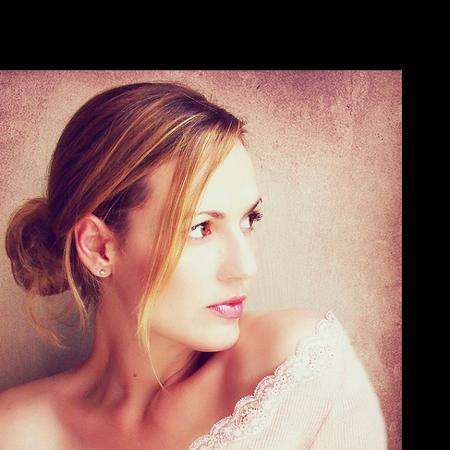

In [10]:
img = cv2.imread(df.iloc[0]['image']+'.jpg')
cv2_imshow(img)

explore the .mat file for that image

In [11]:
annots = loadmat(df.iloc[0]['image']+'.mat')
annots

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 29 22:50:59 2016',
 '__version__': '1.0',
 '__globals__': [],
 'pt2d': array([[ -1.        , 195.96919918, 223.6899384 , 244.94250513,
         260.65092402,  -1.        , 184.88090349, 205.20944559,
         210.75359343,  -1.        , 251.41067762,  -1.        ,
         112.80698152, 219.99383984, 256.03080082,  -1.        ,
          -1.        , 207.05749487, 234.77823409,  -1.        ,
         235.70225873],
        [452.        , 215.37371663, 217.22176591, 217.22176591,
         199.66529774, 452.        , 233.85420945, 229.23408624,
         232.9301848 , 452.        , 220.91786448, 452.        ,
         271.73921971, 280.97946612, 272.66324435, 452.        ,
         452.        , 306.85215606, 304.08008214, 452.        ,
         344.73716632]]),
 'Illum_Para': array([[ 1.08502173e+00,  1.14711392e+00,  1.00629604e+00,
         -4.79617342e-02,  2.16497153e-01,  4.69391227e-01,
          2.2375309

We are only interested in the pose parameters to get the pitch, yaw, and roll

In [12]:
annots['Pose_Para'][0][0:3]

array([-0.3049607 , -0.8197429 ,  0.03717138], dtype=float32)

# 3. Extract 2D Face Points & Save Ground Truth

We will use MediaPipe Face Mesh solution to extract the 2D semantic contours of the face as shown in the bellow figure.

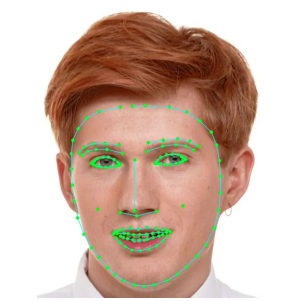

MediaPipe Face Mesh is a solution that estimates 478 3D face landmarks in real-time even on mobile devices. It employs machine learning (ML) to infer the 3D facial surface

You can learn more about mediapipe from [here](https://google.github.io/mediapipe/solutions/face_mesh.html)

Add another column (landmark) to the dataframe which will hold the 478 (x & y) face points of each image

Also add the pitch, yaw and roll columns

In [19]:
l_count = 478
landmarks = ['l' + str(i) for i in range(l_count*2)]
landmarks[:5]

['l0', 'l1', 'l2', 'l3', 'l4']

In [ ]:
df[landmarks] = 0
df['pitch'] = 0.0
df['yaw'] = 0.0
df['roll'] = 0.0

In [25]:
df.head()

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image01598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,/content/AFLW2000/image01097,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2,/content/AFLW2000/image01506,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3,/content/AFLW2000/image02556,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,/content/AFLW2000/image00667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


use face_mesh to extract the face points form each image

In [53]:
def get_2d_features(file):
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.3) as face_mesh:
    image = cv2.imread(file)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
      face_landmarks = list(results.multi_face_landmarks[0].landmark)
      face_landmarks_2d = list(map(lambda landmark: [int(landmark.x * image.shape[0]), int(landmark.y * image.shape[1])], face_landmarks))
      return np.array(face_landmarks_2d, dtype=int).flatten()
    
    return None

In [27]:
def get_pitch_yaw_roll(file):
  annots = loadmat(file)
  return annots['Pose_Para'][0][0], annots['Pose_Para'][0][1], annots['Pose_Para'][0][2]

for each image extract its 2D features, read its labels and save them in the dataframe

In [54]:
for i in range(df.shape[0]):
  image_name = df['image'].iloc[i]
  image_file = image_name + '.jpg'
  mat_file = image_name + '.mat'
  # extract & save 2D features
  df.iloc[i, 1:-3] = get_2d_features(image_file)

  # read & save the three angels
  pose_parameters = get_pitch_yaw_roll(mat_file)
  # Pitch
  df.iloc[i, -3] = pose_parameters[0]
  # Yaw
  df.iloc[i, -2] = pose_parameters[1]
  # Roll
  df.iloc[i, -1] = pose_parameters[2]

take a look at the dataframe, and we notice there are some images with no landmarks as the facemesh has not detected a face in those images, so we will drop them from the dataframe as they are only few compared to the length of the dataset

In [55]:
df.head(6)

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image01598,237.0,296.0,256.0,274.0,245.0,280.0,244.0,252.0,257.0,...,221.0,250.0,216.0,247.0,221.0,249.0,227.0,-0.304961,-0.819743,0.037171
1,/content/AFLW2000/image01097,208.0,307.0,222.0,292.0,216.0,293.0,222.0,258.0,225.0,...,229.0,279.0,222.0,271.0,226.0,276.0,233.0,-0.544066,0.003593,0.362706
2,/content/AFLW2000/image01506,254.0,299.0,273.0,262.0,261.0,273.0,258.0,242.0,274.0,...,217.0,261.0,212.0,259.0,217.0,262.0,222.0,0.208705,-1.244902,-0.247792
3,/content/AFLW2000/image02556,236.0,307.0,214.0,286.0,224.0,289.0,201.0,258.0,210.0,...,201.0,243.0,197.0,239.0,207.0,250.0,211.0,-0.391323,0.342428,-0.483296
4,/content/AFLW2000/image00667,220.0,292.0,214.0,276.0,219.0,280.0,208.0,247.0,213.0,...,214.0,258.0,207.0,251.0,216.0,260.0,222.0,-0.280356,0.295803,-0.133340
5,/content/AFLW2000/image03244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320576,1.311881,0.435426


In [58]:
df[df['l0'].isna()]

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
5,/content/AFLW2000/image03244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320576,1.311881,0.435426
61,/content/AFLW2000/image03996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.675857,-1.460313,0.568137
83,/content/AFLW2000/image01818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.174403,-1.289079,1.272773
103,/content/AFLW2000/image03286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.768587,0.982309,-1.514971
137,/content/AFLW2000/image01530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.724188,-1.825346,5.829394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,/content/AFLW2000/image04161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.402773,1.205008,-1.042042
1921,/content/AFLW2000/image03022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112149,-1.334735,-0.162295
1935,/content/AFLW2000/image02540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026632,1.345040,0.166033
1977,/content/AFLW2000/image02629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.832099,-1.175254,-0.778491


In [59]:
new_df = df.drop(df[df['l0'].isna()].index)

In [63]:
new_df[landmarks] = new_df[landmarks].astype(int)

In [64]:
new_df.head()

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image01598,237,296,256,274,245,280,244,252,257,...,221,250,216,247,221,249,227,-0.304961,-0.819743,0.037171
1,/content/AFLW2000/image01097,208,307,222,292,216,293,222,258,225,...,229,279,222,271,226,276,233,-0.544066,0.003593,0.362706
2,/content/AFLW2000/image01506,254,299,273,262,261,273,258,242,274,...,217,261,212,259,217,262,222,0.208705,-1.244902,-0.247792
3,/content/AFLW2000/image02556,236,307,214,286,224,289,201,258,210,...,201,243,197,239,207,250,211,-0.391323,0.342428,-0.483296
4,/content/AFLW2000/image00667,220,292,214,276,219,280,208,247,213,...,214,258,207,251,216,260,222,-0.280356,0.295803,-0.133340


double check that there is no nones

In [65]:
new_df[new_df['l0'].isna()]

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll


# Visualize The Face Points And Axes

In [47]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

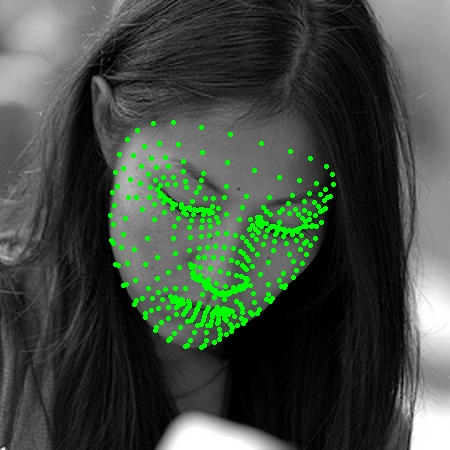

In [76]:
idx = 1
image_file = new_df['image'].iloc[idx] + '.jpg'
image = cv2.imread(image_file)
for x, y in zip(new_df.iloc[idx, 1:-3:2], new_df.iloc[idx, 2:-3:2]):
  cv2.circle(image, (x, y), radius=1, color=(0, 255, 0), thickness=2)

cv2_imshow(image)

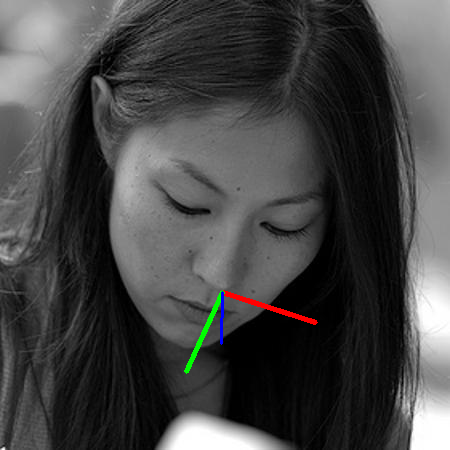

In [77]:
image = cv2.imread(image_file)
tdx, tdy = new_df[['l2', 'l3']].iloc[idx]
annotated_image = draw_axis(image, new_df['pitch'].iloc[idx], new_df['yaw'].iloc[idx], new_df['roll'].iloc[idx], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

Save a copy of this dataframe

In [78]:
new_df.to_csv('/content/data.csv', index=None)

# Explore the Features & Labels 

In [79]:
load_df = pd.read_csv('/content/data.csv')

In [80]:
load_df.head()

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image01598,237,296,256,274,245,280,244,252,257,...,221,250,216,247,221,249,227,-0.304961,-0.819743,0.037171
1,/content/AFLW2000/image01097,208,307,222,292,216,293,222,258,225,...,229,279,222,271,226,276,233,-0.544066,0.003593,0.362706
2,/content/AFLW2000/image01506,254,299,273,262,261,273,258,242,274,...,217,261,212,259,217,262,222,0.208705,-1.244902,-0.247792
3,/content/AFLW2000/image02556,236,307,214,286,224,289,201,258,210,...,201,243,197,239,207,250,211,-0.391323,0.342428,-0.483296
4,/content/AFLW2000/image00667,220,292,214,276,219,280,208,247,213,...,214,258,207,251,216,260,222,-0.280356,0.295803,-0.133340


observe the distribution of the features and labels

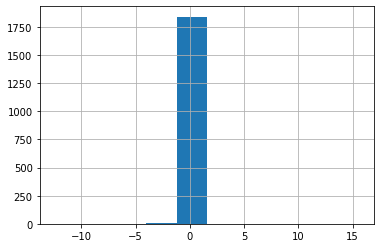

In [81]:
load_df['pitch'].hist()

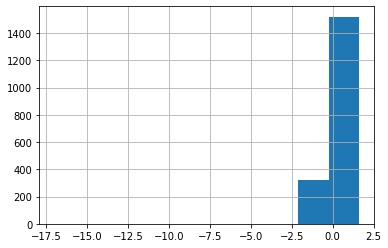

In [82]:
load_df['roll'].hist()

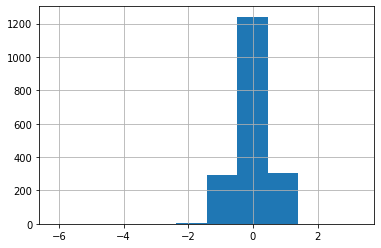

In [83]:
load_df['yaw'].hist()

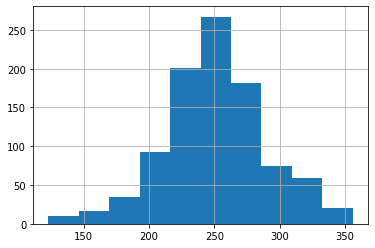

In [88]:
load_df.iloc[2, 1:-3].hist()

In [127]:
import matplotlib.pyplot as plt

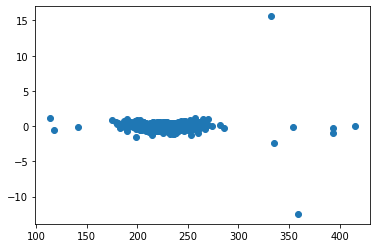

In [141]:
plt.scatter(load_df.iloc[:, 1],load_df['pitch'])

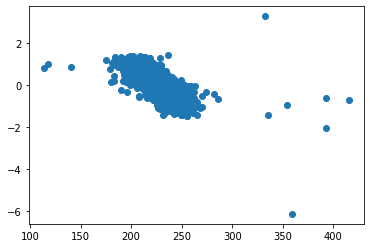

In [142]:
plt.scatter(load_df.iloc[:, 1], load_df['yaw'])

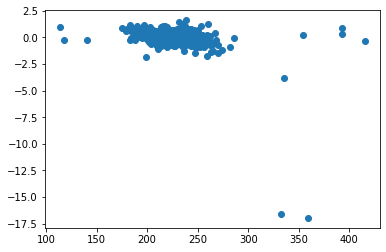

In [143]:
plt.scatter(load_df.iloc[:, 1], load_df['roll'])

# Date Splitting

we will split the date into (train, validations, test) with the ratio (70, 20, 10) as the data is not so big

In [89]:
X = load_df.iloc[:, 1:-3]

In [90]:
X.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
0,237,296,256,274,245,280,244,252,257,267,...,250,221,251,221,250,216,247,221,249,227
1,208,307,222,292,216,293,222,258,225,286,...,278,227,284,229,279,222,271,226,276,233
2,254,299,273,262,261,273,258,242,274,255,...,261,217,264,217,261,212,259,217,262,222
3,236,307,214,286,224,289,201,258,210,278,...,246,204,254,201,243,197,239,207,250,211
4,220,292,214,276,219,280,208,247,213,268,...,259,215,268,214,258,207,251,216,260,222


In [91]:
y = load_df[['pitch', 'yaw', 'roll']] 

In [92]:
y.head()

,pitch,yaw,roll
0,-0.304961,-0.819743,0.037171
1,-0.544066,0.003593,0.362706
2,0.208705,-1.244902,-0.247792
3,-0.391323,0.342428,-0.483296
4,-0.280356,0.295803,-0.133340


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [96]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [97]:
X_train.shape

(1292, 956)

In [98]:
X_val.shape

(371, 956)

In [99]:
X_test.shape

(183, 956)

# Feature Scaling

we will use standardization scaling as the data has a normal distribution

In [126]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaled_x_val = scaler.transform(X_val)
scaled_x_test = scaler.transform(X_test)

# Train Different Models

We will try different models for this problem and pick the best one

In [235]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [189]:
def evaluate_model(model):
  print("model score: ", model.score(scaled_x_val, y_val))
  y_train_predict=model.predict(scaled_x_train)
  y_val_predict=model.predict(scaled_x_val)
  print("model training error: ", np.sqrt(mean_squared_error(y_train,y_train_predict)))
  print("model validation error: ", np.sqrt(mean_squared_error(y_val,y_val_predict)))

## linear regression

In [104]:
pitch_reg = LinearRegression().fit(scaled_x_train, y_train['pitch'])
pitch_reg.score(scaled_x_val, y_val['pitch'])

-9.765324863715692

In [106]:
yaw_reg = LinearRegression().fit(scaled_x_train, y_train['yaw'])
pitch_reg.score(scaled_x_val, y_val['yaw'])

-2.472834363010961

In [105]:
pitch_reg = LinearRegression().fit(scaled_x_train, y_train['roll'])
pitch_reg.score(scaled_x_val, y_val['roll'])

-3.2576378225192

try multi regressor

In [194]:
from sklearn.multioutput import MultiOutputRegressor

In [198]:
multi_reg = MultiOutputRegressor(LinearRegression()).fit(scaled_x_train, y_train)
evaluate_model(multi_reg)

model score:  -4.159570625143073
model training error:  0.20615575885820236
model validation error:  0.74128054311363


## lasso

In [201]:
multi_poly_reg = MultiOutputRegressor(Lasso(alpha=0.005)).fit(scaled_x_train, y_train)
evaluate_model(multi_poly_reg)

model score:  0.554751449798034
model training error:  0.4999245319624711
model validation error:  0.23514101824381428


In [200]:
multi_poly_reg = MultiOutputRegressor(Lasso(alpha=0.01)).fit(scaled_x_train, y_train)
evaluate_model(multi_poly_reg)

model score:  0.531671009703088
model training error:  0.5175300057991291
model validation error:  0.23897105816922698


## Ridge

In [204]:
multi_ridge_reg = MultiOutputRegressor(Ridge(alpha=0.5)).fit(scaled_x_train, y_train)
evaluate_model(multi_ridge_reg)

model score:  0.26083122539470804
model training error:  0.45880609058476834
model validation error:  0.3055003817376738


In [203]:
multi_ridge_reg = MultiOutputRegressor(Ridge(alpha=0.1)).fit(scaled_x_train, y_train)
evaluate_model(multi_ridge_reg)

model score:  0.24051077781533747
model training error:  0.43240895246883676
model validation error:  0.30552832461243756


## SVR

The best validation error after tuning the SVR

In [213]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.7149336979948031
model training error:  0.48152934154570215
model validation error:  0.1907136645652423


### Tuning the SVR parameters

In [206]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1, coef0=1)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.4422369644896407
model training error:  0.49985936104660655
model validation error:  0.25884799636449857


In [212]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.7064421100038206
model training error:  0.5028263498491728
model validation error:  0.19442723644008544


In [211]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.5, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.6123641034457236
model training error:  0.502189112612448
model validation error:  0.22668048911281577


In [218]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=10, degree=2, epsilon=.5, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.24995039373019914
model training error:  0.41447930716144327
model validation error:  0.3150104477032253


In [219]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=2, degree=2, epsilon=.5, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.567766086172886
model training error:  0.46732818424927897
model validation error:  0.2399205416094313


In [215]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', gamma='auto', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.488270207198286
model training error:  0.5547953515862437
model validation error:  0.2837216350944084


In [214]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', degree=3, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.4237019001309663
model training error:  0.319072310825294
model validation error:  0.2569242881414698


## Decision Tree

The best validation error after tuning the Decision Tree

In [223]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.6467998683155566
model training error:  0.13094337158573943
model validation error:  0.20571011629443745


### Tuning the Decision Tree

In [222]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=2)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.3546225096067756
model training error:  0.26535084477202475
model validation error:  0.28448662360528826


In [233]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=4)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.6359520711104182
model training error:  0.15433167827104732
model validation error:  0.21121706257413547


In [231]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=10)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.6056645795283949
model training error:  0.05534005657938151
model validation error:  0.21571337882400868


## Random Forest

The best validation error after tuning the Random Forest

In [242]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=7)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.7070045736361958
model training error:  0.24569821152827367
model validation error:  0.18954098854429335


### Tuning the Random Forest

In [238]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=4)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.5835870855574902
model training error:  0.21393480449090768
model validation error:  0.2256150959936542


In [237]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=5)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.7028100971258763
model training error:  0.21462970036036025
model validation error:  0.19118556095124742


In [240]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=6)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.7106691537301605
model training error:  0.26276724126065115
model validation error:  0.18805635757702502


In [241]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=8)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.7080051291751451
model training error:  0.22691611655605567
model validation error:  0.1894563944161828


## Training Conclusion

|Metric         |Linear Regression |Lasso|Ridge|SVR|Decision Tree|Random Forest
|---------------|:-----------------|:-----------------|:-----------------|:-----------------|:-----------------|:-----------------|
|Accuracy       |-4.16|0.55|0.26|0.71|0.65|0.81|
|Training RMSE  |0.21|0.5|0.46|0.48|0.13|0.27|
|Validation RMSE|0.74|0.24|0.31|0.19|0.21|0.15|


We conclude that random forest has the best performance

# Test Model

In [243]:
final_model = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=7)).fit(scaled_x_train, y_train)
y_test_predict=final_model.predict(scaled_x_test)
print("model test error: ", np.sqrt(mean_squared_error(y_test,y_test_predict)))

model test error:  0.1166067901702187


In [274]:
final_model_2 = MultiOutputRegressor(SVR(kernel='poly', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
y_test_predict=final_model_2.predict(scaled_x_test)
print("model test error: ", np.sqrt(mean_squared_error(y_test,y_test_predict)))

model test error:  0.12590603408738713


# Save Model

In [314]:
import joblib

In [315]:
joblib.dump(final_model, '/content/model.pkl')

['/content/model.pkl']

# Predict

In [316]:
model = joblib.load('/content/model.pkl')

In [244]:
y_test.head()

,pitch,yaw,roll
350,-0.263200,-0.954269,0.371615
383,-0.325306,-0.496742,-0.011608
974,-0.137476,0.368632,0.236267
1636,-0.040060,0.711913,0.082239
1177,-0.270616,-1.031000,0.495276


In [309]:
idx = 383
predict_trial_landmarks = load_df.iloc[idx, 1:-3]
scaled_predict_trial_landmarks = scaler.transform(predict_trial_landmarks.values.reshape(1, -1))
scaled_predict_trial_landmarks.shape

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(1, 956)

In [317]:
predicted_pose = model.predict(scaled_predict_trial_landmarks)
predicted_pose

array([[-0.25045695, -0.51354655, -0.03321729]])

In [311]:
image_file = new_df['image'].iloc[idx] + '.jpg'
image = cv2.imread(image_file)
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]

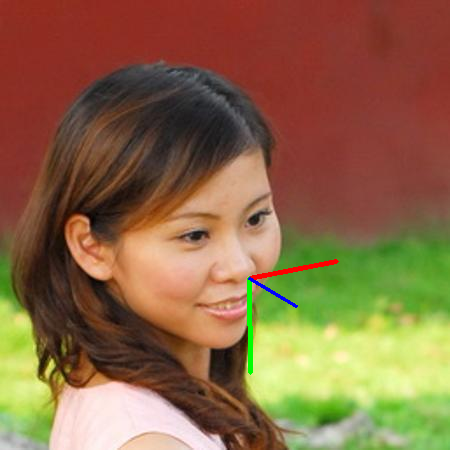

In [312]:
annotated_image = draw_axis(image, load_df['pitch'].iloc[idx], load_df['yaw'].iloc[idx], new_df['roll'].iloc[idx], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

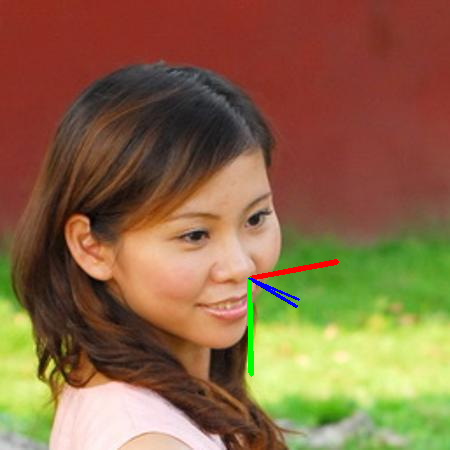

In [313]:
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]
annotated_image = draw_axis(image, predicted_pose[0][0], predicted_pose[0][1], predicted_pose[0][2], tdx, tdy, size = 100)
cv2_imshow(annotated_image)